In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import pickle
import time

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import optimize, stats
from scipy.special import comb

In [2]:
%pwd

'c:\\Users\\Admin\\PhD Projects\\balance_continuous\\research'

In [3]:
PROJECT_ROOT = Path(os.getcwd()).parent
DATA_DIR = PROJECT_ROOT / 'data'

In [4]:
# os.chdir("../")
%pwd

'c:\\Users\\Admin\\PhD Projects\\balance_continuous\\research'

### Kendall tau estimation

In [5]:
def bw_scott(data: np.ndarray):
    std_dev = np.std(data, axis=0, ddof=1)
    n = len(data)
    return 3.49 * std_dev * n ** (-0.333)

def bw_silverman(data: np.ndarray):
    def _select_sigma(x):
        normalizer = 1.349
        iqr = (stats.scoreatpercentile(x, 75) - stats.scoreatpercentile(x, 25)) / normalizer
        std_dev = np.std(x, axis=0, ddof=1)
        return np.minimum(std_dev, iqr) if iqr > 0 else std_dev
    sigma = _select_sigma(data)
    n = len(data)
    return 0.9 * sigma * n ** (-0.2)

def bw_mlcv(data: np.ndarray, k):
    """
    Ref: https://rdrr.io/cran/kedd/src/R/MLCV.R
    """
    n = len(data)
    x = np.linspace(np.min(data), np.max(data), n)
    def mlcv(h):
        fj = np.zeros(n)
        for j in range(n):
            for i in range(n):
                if i == j: continue
                fj[j] += k((x[j] - data[i]) / h)
            fj[j] /= (n - 1) * h
        return -np.mean(np.log(fj[fj > 0]))
    h = optimize.minimize(mlcv, 1)
    if np.abs(h.x[0]) > 10:
        return bw_scott(data)
    return h.x[0]


In [6]:
def kernel(k: str):
    """Kernel function

    Args:
        k (str): kernel name: ['gaussian', 'epanechnikov']
    """
    if k not in ['gaussian', 'epanechnikov']:
        raise ValueError('Unknown kernel')
    
    def bounded(f): # decorator
        def _f(x):  # wrapper function
            return f(x) if np.abs(x) <= 1 else 0
        return _f
    
    if k == 'gaussian':
        return lambda u: 1 / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * u * u)
    elif k == 'epanechnikov':
        return bounded(lambda u: (3 / 4 * (1 - u * u)))
    
    
def kernel_weights(t, s, h, S, k=None):
    if k is None:
        k = kernel('epanechnikov')
    wh = k((t - s)/(S*h))
    return wh/(S*h)

# calculate tau 
def kendall_tau_estimator(Y_A, Y_B, h=None):
    start = time.time()
    assert len(Y_A) == len(Y_B), "Length Y_A and Y_B must be same"
    if h is None:
        h = 0.1
        print(h)
    S = len(Y_A) # both Y_A and Y_B needs to be of equal length
    tau_estimates = []
    # Create kernel function
    # k = kernel('epanechnikov')
    Y_A_comparison = Y_A[:, np.newaxis] < Y_A[np.newaxis, :]  # Shape: (S, S)
    Y_B_comparison = Y_B[:, np.newaxis] < Y_B[np.newaxis, :]  # Shape: (S, S)
    for t in range(1,S+1):
        # weights = np.array([k((t - s) / (S * h)) / (S * h) for s in range(1, S + 1)])
        weights = np.array([kernel_weights(t, s, h, S) for s in range(1, S+1)])
        normalize = 1 - np.sum(weights**2)
        if normalize <=0:
            raise ValueError("Normalization is less than 0, Adjust 'h'")
        summed_weights = 0
        # for s_idx, s in enumerate(range(1, S + 1)):
        #     for r_idx, r in enumerate(range(1, S + 1)):
        #         # Indicator function: I[{Y_A(s) < Y_A(r), Y_B(s) < Y_B(r)}]
        #         # Using 0-indexing for arrays
        #         indicator = int((Y_A[s_idx] < Y_A[r_idx]) and (Y_B[s_idx] < Y_B[r_idx]))
                
        #         summed_weights += weights[s_idx] * weights[r_idx] * indicator
        # Vectorized computation using broadcasting
        # Create comparison matrices
        
        
        # Concordant pairs indicator
        indicator_matrix = (Y_A_comparison & Y_B_comparison).astype(int)
        
        # Weight matrix (outer product)
        weight_matrix = weights[:, np.newaxis] * weights[np.newaxis, :]  # Shape: (S, S)
        
        # Sum all weighted indicators
        summed_weights = np.sum(weight_matrix * indicator_matrix)
        tau_t = (4/normalize )*summed_weights-1
        tau_estimates.append(tau_t)
    end = time.time()
    print(f"Time elapsed: {end-start} s")
    return tau_estimates

### New version for tau

In [7]:
def kendall_tau_estimator_ultra_fast(Y_A, Y_B, h=None):
    """
    Ultra-fast version with maximum vectorization
    
    Key optimizations:
    - Pre-compute ALL weight matrices at once
    - Single matrix multiplication for all time points
    - Minimize loop iterations
    """
    assert len(Y_A) == len(Y_B), "Length Y_A and Y_B must be same"
    
    if h is None:
        h = 0.1
    
    S = len(Y_A)
    
    # Pre-compute comparison matrix (only once!)
    Y_A_comparison = Y_A[:, np.newaxis] < Y_A[np.newaxis, :]
    Y_B_comparison = Y_B[:, np.newaxis] < Y_B[np.newaxis, :]
    indicator_matrix = (Y_A_comparison & Y_B_comparison).astype(np.float32)
    
    # Vectorized kernel function
    def epanechnikov_bounded(u):
        result = 0.75 * (1 - u * u)
        result[np.abs(u) > 1] = 0
        return result
    
    # Create all time points at once
    t_values = np.arange(1, S + 1)[:, np.newaxis]  # Shape: (S, 1)
    s_values = np.arange(1, S + 1)[np.newaxis, :]  # Shape: (1, S)
    
    # Compute all weights at once - Shape: (S, S)
    u = (t_values - s_values) / (S * h)
    all_weights = epanechnikov_bounded(u) / (S * h)
    
    # Compute normalization factors for all time points
    normalize = 1 - np.sum(all_weights**2, axis=1)
    
    if np.any(normalize <= 0):
        bad_indices = np.where(normalize <= 0)[0]
        raise ValueError(f"Normalization ≤ 0 at indices {bad_indices}. Increase 'h' (current h={h})")
    
    # Compute tau for all time points at once
    tau_estimates = np.zeros(S)
    
    for t_idx in range(S):
        weights_t = all_weights[t_idx]
        weight_matrix = np.outer(weights_t, weights_t)
        summed_weights = np.sum(weight_matrix * indicator_matrix)
        tau_estimates[t_idx] = (4 / normalize[t_idx]) * summed_weights - 1
    
    return tau_estimates

In [5]:
from numba import jit

@jit(nopython=True, parallel=True)
def _compute_tau_numba(indicator_matrix, all_weights, S):
    """JIT-compiled computation of tau estimates"""
    tau_estimates = np.zeros(S)
    
    for t_idx in range(S):
        weights_t = all_weights[t_idx]
        normalize = 1 - np.sum(weights_t**2)
        
        if normalize <= 0:
            tau_estimates[t_idx] = np.nan
            continue
        
        summed_weights = 0.0
        for i in range(S):
            for j in range(S):
                summed_weights += weights_t[i] * weights_t[j] * indicator_matrix[i, j]
        
        tau_estimates[t_idx] = (4 / normalize) * summed_weights - 1
    
    return tau_estimates


def kendall_tau_estimator_numba(Y_A, Y_B, h=None):
    """
    Numba-accelerated version for maximum speed
    Can be 50-500x faster for large datasets
    """
    assert len(Y_A) == len(Y_B), "Length Y_A and Y_B must be same"
    
    if h is None:
        h = 0.1
    
    S = len(Y_A)
    
    # Pre-compute comparison matrix
    Y_A_comparison = Y_A[:, np.newaxis] < Y_A[np.newaxis, :]
    Y_B_comparison = Y_B[:, np.newaxis] < Y_B[np.newaxis, :]
    indicator_matrix = (Y_A_comparison & Y_B_comparison).astype(np.float64)
    
    # Compute all weights
    t_values = np.arange(1, S + 1)[:, np.newaxis]
    s_values = np.arange(1, S + 1)[np.newaxis, :]
    
    u = (t_values - s_values) / (S * h)
    
    # Epanechnikov kernel
    kernel_vals = 0.75 * (1 - u * u)
    kernel_vals[np.abs(u) > 1] = 0
    all_weights = kernel_vals / (S * h)
    
    # Call JIT-compiled function
    tau_estimates = _compute_tau_numba(indicator_matrix, all_weights, S)
    
    return tau_estimates

In [7]:
Y_A = np.array([1, 3, 2, 4])
# Y_B = np.array([2, 4, 1, 3])
Y_B = Y_A
print(Y_A)
Y_A_comparison = Y_A[:, np.newaxis] < Y_A[np.newaxis, :] 
Y_B_comparison = Y_B.reshape(-1, 1) < Y_B.reshape(1, -1)
indicator_matrix = (Y_A_comparison & Y_B_comparison).astype(int)
print(indicator_matrix)

[1 3 2 4]
[[0 1 1 1]
 [0 0 0 1]
 [0 1 0 1]
 [0 0 0 0]]


In [8]:
weights = np.array([1, 2, 1, 3])
print(weights)
weight_matrix = weights.reshape(-1, 1) * weights.reshape(1, -1)
print(weight_matrix)
np.sum(weight_matrix*indicator_matrix)

[1 2 1 3]
[[1 2 1 3]
 [2 4 2 6]
 [1 2 1 3]
 [3 6 3 9]]


np.int64(17)

Tau estimate at t=100 is 0.9995951619433687
Tau estimate at t=500 is 0.9995951619433687
Tau estimate at t=900 is 0.9995951619433687


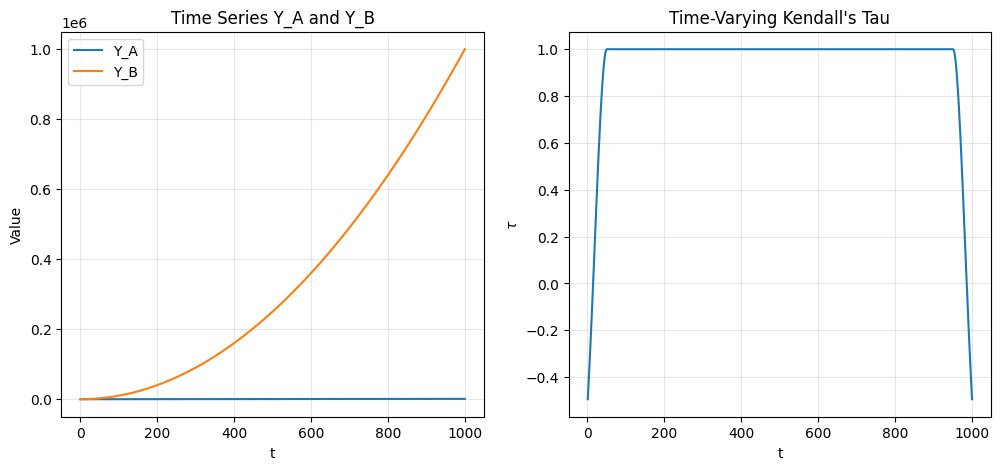

In [12]:
# test 1
Y_A = np.arange(1, 1001)
Y_B = np.power(Y_A, 2)
# Y_B = np.arange(100, 199)
S = 1000
t = np.arange(1, S+1)
# tau_estimate = kendall_tau_estimator(Y_A, Y_B, h=0.05)
tau_estimate = kendall_tau_estimator_numba(Y_A, Y_B, h=0.05)
for time_point in [100, 500, 900]:
    print(f"Tau estimate at t={time_point} is {tau_estimate[time_point]}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(t, Y_A, label='Y_A')
ax1.plot(t, Y_B, label='Y_B')
ax1.set_xlabel('t')
ax1.set_ylabel('Value')
ax1.grid(True, alpha=0.3)
ax1.set_title('Time Series Y_A and Y_B')
ax1.legend()

ax2.plot(t, tau_estimate)
ax2.set_xlabel('t')
ax2.set_ylabel(r'$\tau$')
ax2.set_title("Time-Varying Kendall's Tau")
ax2.grid(True, alpha=0.3)

#### Kendall estimation for two stocks

In [6]:
# load data
tickers_df = pd.read_parquet(PROJECT_ROOT/'artifacts/data_ingestion/tickers_df.parquet')
tickers_df.head()

Price,Adj Close,Close,High,Low,Open,Volume,Ticker,Year,Month,Weekday,Date
0,0.840094,0.999442,1.004464,0.907924,0.936384,535796800,AAPL,2000,1,0,2000-01-03
1,0.769266,0.915179,0.987723,0.903460,0.966518,512377600,AAPL,2000,1,1,2000-01-04
2,0.780523,0.928571,0.987165,0.919643,0.926339,778321600,AAPL,2000,1,2,2000-01-05
3,0.712977,0.848214,0.955357,0.848214,0.947545,767972800,AAPL,2000,1,3,2000-01-06
4,0.746751,0.888393,0.901786,0.852679,0.861607,460734400,AAPL,2000,1,4,2000-01-07


In [7]:
len(tickers_df)

300923

In [8]:
# calculate log returns


In [12]:
start_date = pd.to_datetime('2000-01-04')
end_date = pd.to_datetime('2000-05-01')

# Filter for a date range
price_data_range = tickers_df[
    (tickers_df['Date'] >= start_date) & 
    (tickers_df['Date'] <= end_date)
]
# ticker_given_date = tickers_df[tickers_df['Date']==choose_date]

# ticker_given_date = ticker_given_date[['Date','Adj Close', 'Ticker']].reset_index(drop=True)
# ticker_given_date.head()

In [13]:
price_data = price_data_range.pivot(index='Date', columns='Ticker', values='Adj Close')
price_data.head()

Ticker,AAPL,ABT,ADBE,AMD,AMZN,BAC,BRK-B,CAT,COST,CSCO,...,PEP,PG,QCOM,TMO,TXN,UNH,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,0.769266,7.901649,14.909400,14.625,4.096875,11.749413,34.080002,12.412427,28.140806,33.176208,...,18.680834,26.689560,50.451542,11.771195,30.446939,5.177938,15.072995,9.219257,13.706803,17.073050
2000-01-05,0.780523,7.887130,15.204173,15.000,3.487500,11.878349,34.639999,12.703344,28.621675,33.074562,...,18.225986,26.181787,48.700462,11.873114,29.712830,5.165741,15.576519,9.126291,13.427075,18.003799
2000-01-06,0.712977,8.163106,15.328291,16.000,3.278125,12.893733,36.080002,13.349825,29.196608,32.525688,...,19.038191,27.387732,43.602760,11.873114,28.901415,5.354805,15.497395,9.529145,13.573600,18.934546
2000-01-07,0.746751,8.250252,16.072983,16.250,3.478125,12.555274,36.400002,13.786188,31.130516,34.436569,...,19.558006,29.577484,46.696384,12.025988,29.055969,5.982991,15.382956,9.699590,14.599277,18.878977
2000-01-10,0.733617,8.192155,16.693565,17.500,3.459375,12.120110,36.259998,13.333663,31.778637,35.717266,...,19.168159,29.434658,49.614918,11.924072,31.045824,5.879308,15.301218,9.389695,14.332864,18.615034


In [14]:
len(price_data)

82

<Axes: xlabel='Ticker', ylabel='Ticker'>

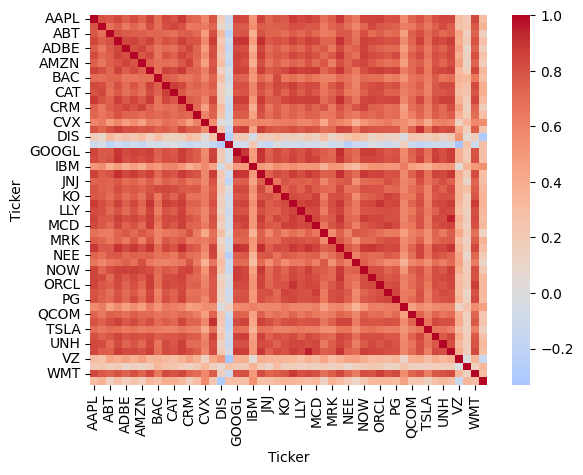

In [11]:
corr = price_data.corr(method='kendall')
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)

In [7]:
def plot_prices_tau(Y_A, Y_B, tau_estimate, t=None):
    S = len(Y_A)
    if t is None:
        t = np.arange(1, S+1)
    for time_point in [10, 50]:
        print(f"Tau estimate at t={time_point} is {tau_estimate[time_point]}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(t, Y_A, label='Y_A')
    ax1.plot(t, Y_B, label='Y_B')
    ax1.set_xlabel('t')
    ax1.set_ylabel('Value')
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Time Series Y_A and Y_B')
    ax1.legend()

    ax2.plot(t, tau_estimate)
    ax2.set_xlabel('t')
    ax2.set_ylabel(r'$\tau$')
    ax2.set_title("Time-Varying Kendall's Tau")
    ax2.grid(True, alpha=0.3)

In [97]:
Y_A = price_data['AAPL'].dropna().to_numpy()
Y_B = price_data['TXN'].dropna().to_numpy()
date = price_data.index.to_list()

In [98]:
tau_estimate = kendall_tau_estimator_numba(Y_A, Y_B, h=0.1)

Tau estimate at t=10 is 0.7099378843651791
Tau estimate at t=50 is 0.4946987302926864


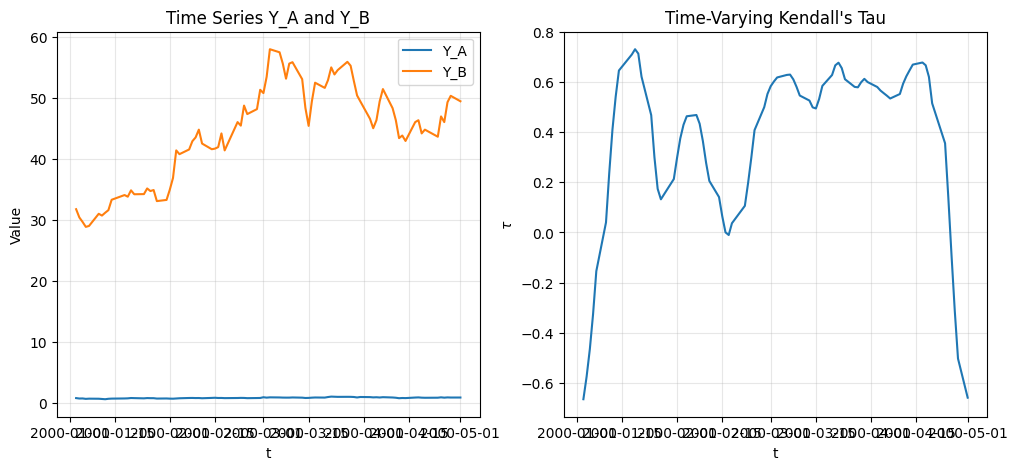

In [53]:
plot_prices_tau(Y_A, Y_B, tau_estimate, t=date)

In [ ]:
tau_data = {'Date': price_data_range['Date']}
tau_data['TickerAB'] = tau_estimate


Select the date range

In [8]:
start_date = pd.to_datetime('2000-01-01')
end_date = pd.to_datetime('2000-05-31')

# Filter for a date range
price_data_range = tickers_df[
    (tickers_df['Date'] >= start_date) & 
    (tickers_df['Date'] <= end_date)
]
price_data = price_data_range.pivot(index='Date', columns='Ticker', values='Adj Close')
len(price_data)

104

In [9]:
price_data.shape

(104, 38)

Select the tickers

In [10]:
ticker_name = list(price_data.columns) 

In [74]:
tau_stocks = []
for i in range(len(ticker_name)):
    tickerA = ticker_name[i]
    YA = price_data[tickerA].to_numpy()
    for j in range(i, len(ticker_name)):
        tickerB = ticker_name[j]
        YB = price_data[tickerB].to_numpy()
        tau_AB = kendall_tau_estimator_numba(YA, YB, h=0.1)
        print(i,j, tickerA, tickerB)
        tau_stocks.append(tau_AB)

# save the estimated kendall tau as a pickle file
# with open('tau_stocks_alltime','wb') as f:
#     pickle.dump(tau_stocks, f)

0 0 AAPL AAPL
0 1 AAPL ABT
0 2 AAPL ADBE
0 3 AAPL AMD
0 4 AAPL AMZN
0 5 AAPL BAC
0 6 AAPL BRK-B
0 7 AAPL CAT
0 8 AAPL COST
0 9 AAPL CSCO
0 10 AAPL CVX
0 11 AAPL DHR
0 12 AAPL DIS
0 13 AAPL GE
0 14 AAPL HD
0 15 AAPL IBM
0 16 AAPL INTU
0 17 AAPL JNJ
0 18 AAPL JPM
0 19 AAPL KO
0 20 AAPL LIN
0 21 AAPL LLY
0 22 AAPL MCD
0 23 AAPL MRK
0 24 AAPL MSFT
0 25 AAPL NEE
0 26 AAPL NVDA
0 27 AAPL ORCL
0 28 AAPL PEP
0 29 AAPL PG
0 30 AAPL QCOM
0 31 AAPL TMO
0 32 AAPL TXN
0 33 AAPL UNH
0 34 AAPL VZ
0 35 AAPL WFC
0 36 AAPL WMT
0 37 AAPL XOM
1 1 ABT ABT
1 2 ABT ADBE
1 3 ABT AMD
1 4 ABT AMZN
1 5 ABT BAC
1 6 ABT BRK-B
1 7 ABT CAT
1 8 ABT COST
1 9 ABT CSCO
1 10 ABT CVX
1 11 ABT DHR
1 12 ABT DIS
1 13 ABT GE
1 14 ABT HD
1 15 ABT IBM
1 16 ABT INTU
1 17 ABT JNJ
1 18 ABT JPM
1 19 ABT KO
1 20 ABT LIN
1 21 ABT LLY
1 22 ABT MCD
1 23 ABT MRK
1 24 ABT MSFT
1 25 ABT NEE
1 26 ABT NVDA
1 27 ABT ORCL
1 28 ABT PEP
1 29 ABT PG
1 30 ABT QCOM
1 31 ABT TMO
1 32 ABT TXN
1 33 ABT UNH
1 34 ABT VZ
1 35 ABT WFC
1 36 ABT WMT
1 37 A

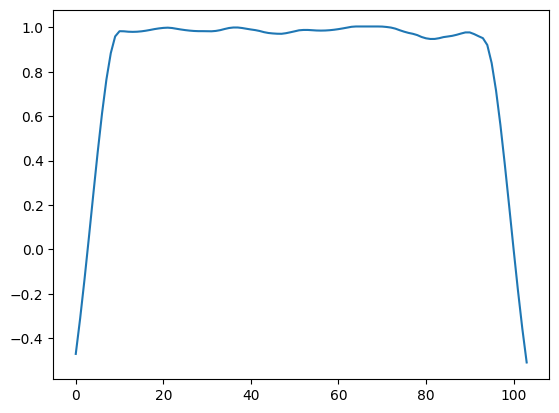

In [12]:
plt.plot(tau_stocks[38])

#### Convert to Correlation matrix

In [63]:
x= np.array(tau_stocks)
x.shape

(15, 251)

In [18]:
x  = [[1,2,1,0], [9,3,1,2], [1,2,3,0], [4,2,1,0],[3,2,5,1], [2,3,1,7]]
x = np.array(x)
len(x[0])

4

In [16]:
def find_matrix_size(tickers):
    m = len(tickers)
    n = (-1 + np.sqrt(1+8*m))/2
    return int(n)

In [17]:
n = find_matrix_size(x)
T = len(x[0])
upp_tri_matrix = np.zeros((T,n,n))
sym_matrix = []
for t in range(T):
    idx=0
    for i in range(n):
        for j in range(i, n):
            upp_tri_matrix[t,i, j]= x[idx][t]
            idx+=1
    sym_matrix_t = np.triu(upp_tri_matrix[t], k=1) + upp_tri_matrix[t].T
    sym_matrix.append(sym_matrix_t)

In [89]:
find_matrix_size(tau_stocks)

50

### Merge data

In [13]:
%pwd

'c:\\Users\\Admin\\PhD Projects\\balance_continuous\\research'

In [6]:
filename = 'tau_AAPL_all.parquet'
tau_A_all =  pd.read_parquet(DATA_DIR/'output_tau_numba'/filename)
tau_A_all.head()

,Date,AAPL_ACGL,AAPL_AFL,AAPL_AIG,AAPL_AJG,AAPL_ALL,AAPL_AON,AAPL_AXP,AAPL_BAC,AAPL_BEN,...,AAPL_SNPS,AAPL_SWKS,AAPL_TDY,AAPL_TER,AAPL_TRMB,AAPL_TXN,AAPL_TYL,AAPL_VRSN,AAPL_WDC,AAPL_ZBRA
0,2000-01-04,-0.738635,-0.746230,-0.744014,-0.748291,-0.733750,-0.736484,-0.715219,-0.715053,-0.717966,...,-0.678073,-0.673225,-0.707285,-0.670519,-0.683895,-0.673203,-0.736160,-0.678907,-0.713396,-0.688812
1,2000-01-05,-0.736631,-0.744209,-0.741958,-0.746254,-0.731648,-0.734363,-0.712927,-0.712752,-0.715678,...,-0.675511,-0.670600,-0.704926,-0.667870,-0.681351,-0.670578,-0.734079,-0.676343,-0.711048,-0.686331
2,2000-01-06,-0.734623,-0.742178,-0.739892,-0.744206,-0.729537,-0.732232,-0.710624,-0.710441,-0.713381,...,-0.672937,-0.667965,-0.702559,-0.665208,-0.678801,-0.667940,-0.731989,-0.673767,-0.708690,-0.683840
3,2000-01-07,-0.732608,-0.740134,-0.737814,-0.742146,-0.727414,-0.730090,-0.708308,-0.708117,-0.711072,...,-0.670357,-0.665317,-0.700179,-0.662533,-0.676236,-0.665288,-0.729894,-0.671179,-0.706318,-0.681337
4,2000-01-10,-0.730586,-0.738080,-0.735725,-0.740079,-0.725280,-0.727939,-0.705983,-0.705781,-0.708753,...,-0.667766,-0.662658,-0.697790,-0.659847,-0.673659,-0.662627,-0.727792,-0.668582,-0.703933,-0.678822


In [15]:
tau_A_all.iloc[0]

Date         2000-01-04 00:00:00
AAPL_ACGL              -0.738635
AAPL_AFL                -0.74623
AAPL_AIG               -0.744014
AAPL_AJG               -0.748291
                    ...         
AAPL_TXN               -0.673203
AAPL_TYL                -0.73616
AAPL_VRSN              -0.678907
AAPL_WDC               -0.713396
AAPL_ZBRA              -0.688812
Name: 0, Length: 91, dtype: object

In [17]:
tau_A_all = tau_A_all.transpose()
tau_A_all = tau_A_all[1:]

Do the same for all the other parquet files

In [7]:
import glob

# get all the parquet files
parquet_dir = DATA_DIR/'output_tau_numba'
print(f"\nParquet directory: {parquet_dir}")
print(f"Directory exists: {parquet_dir.exists()}")
parquet_files = list(parquet_dir.glob('*.parquet'))
print(f"Found {len(parquet_files)} parquet files")
dataframes = []
for file in parquet_files:
    df = pd.read_parquet(file)
    df = df.transpose()
    df = df[1:] # removing the first row (Date)
    dataframes.append(df)

merged_df = pd.concat(dataframes, ignore_index=False)
merged_df.sort_index(ascending=True, inplace=True)
merged_df.columns = merged_df.columns.astype(str)



Parquet directory: c:\Users\Admin\PhD Projects\balance_continuous\data\output_tau_numba
Directory exists: True
Found 90 parquet files


In [8]:


merged_df.to_parquet(DATA_DIR/'tau_estimates.parquet',engine='fastparquet',compression='brotli')


Find the correlation matrix

In [5]:
tau_stocks = pd.read_parquet(DATA_DIR/'tau_estimates.parquet')
tau_stocks.reset_index(drop=True, inplace=True)
tau_stocks.head()

,0,1,2,3,4,5,6,7,8,9,...,3762,3763,3764,3765,3766,3767,3768,3769,3770,3771
0,-0.499409,-0.495421,-0.491418,-0.487399,-0.483365,-0.479314,-0.475249,-0.471168,-0.467071,-0.462959,...,-0.462735,-0.466849,-0.470948,-0.475031,-0.479099,-0.483152,-0.487189,-0.491210,-0.495215,-0.499205
1,-0.738635,-0.736631,-0.734623,-0.732608,-0.730586,-0.728559,-0.726525,-0.724481,-0.722431,-0.720378,...,-0.692227,-0.694478,-0.696717,-0.698944,-0.701162,-0.703379,-0.705597,-0.707809,-0.710007,-0.712204
2,-0.670860,-0.668265,-0.665658,-0.663040,-0.660411,-0.657772,-0.655129,-0.652475,-0.649816,-0.647145,...,-0.677915,-0.680305,-0.682684,-0.685048,-0.687404,-0.689758,-0.692109,-0.694453,-0.696785,-0.699110
3,-0.688508,-0.686032,-0.683545,-0.681043,-0.678531,-0.676011,-0.673482,-0.670938,-0.668388,-0.665831,...,-0.685760,-0.688077,-0.690381,-0.692669,-0.694949,-0.697226,-0.699500,-0.701770,-0.704036,-0.706302
4,-0.746230,-0.744209,-0.742178,-0.740134,-0.738080,-0.736014,-0.733940,-0.731856,-0.729763,-0.727661,...,-0.687171,-0.689480,-0.691778,-0.694059,-0.696333,-0.698603,-0.700873,-0.703138,-0.705401,-0.707665


In [6]:
tau_stocks=tau_stocks.to_numpy()

In [16]:
tau_stocks[2][0]

np.float64(-0.6708600214458653)

In [27]:
n=90
T = len(tau_stocks[0])
corr_matrix = np.zeros((T, n, n))
for t in  range(T):  # time
    idx = 0
    for i in range(n):  # Ticker A
        for j in range(n):  # Ticker B
            corr_matrix[t, i, j] = tau_stocks[idx][t]
            idx+=1

In [28]:
np.shape(corr_matrix[0])

(90, 90)

In [29]:
corr_matrix[0]

array([[-0.49940886, -0.73863479, -0.67086002, ..., -0.73280611,
        -0.74143192, -0.68881194],
       [-0.73863479, -0.51896149, -0.73228356, ..., -0.76956201,
        -0.76267628, -0.73490071],
       [-0.67086002, -0.73228356, -0.49920866, ..., -0.73349344,
        -0.72714394, -0.68716535],
       ...,
       [-0.73280611, -0.76956201, -0.73349344, ..., -0.49935061,
        -0.72136652, -0.75205197],
       [-0.74143192, -0.76267628, -0.72714394, ..., -0.72136652,
        -0.50162922, -0.75184201],
       [-0.68881194, -0.73490071, -0.68716535, ..., -0.75205197,
        -0.75184201, -0.49932516]], shape=(90, 90))

In [13]:
x = np.zeros((2,3,3))
x[0]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [35]:
corr_matrix[0][0]

array([-0.49940886, -0.73863479, -0.67086002, -0.68850807, -0.74623001,
       -0.7440138 , -0.74829082, -0.69797674, -0.73374965, -0.66460566,
       -0.68146434, -0.73648387, -0.69012504, -0.71521949, -0.71505299,
       -0.71796593, -0.73745714, -0.73369397, -0.73178076, -0.71569821,
       -0.72782912, -0.69803987, -0.72515657, -0.71875993, -0.66282222,
       -0.71933143, -0.73953483, -0.73711866, -0.70592576, -0.6827252 ,
       -0.69911349, -0.72176588, -0.72929378, -0.69126857, -0.74221096,
       -0.66980201, -0.70093096, -0.72666053, -0.73474077, -0.67273496,
       -0.69954717, -0.64972862, -0.69238131, -0.71246661, -0.72733745,
       -0.68144107, -0.708177  , -0.70878155, -0.72750325, -0.66130994,
       -0.74160153, -0.67019568, -0.67101042, -0.7373519 , -0.7302607 ,
       -0.69966025, -0.66774305, -0.67208513, -0.72320611, -0.68365579,
       -0.6696108 , -0.72604753, -0.68713948, -0.66576501, -0.74466848,
       -0.72849471, -0.68853008, -0.69127897, -0.72718654, -0.70

In [54]:
def correlation_matrix(tau_stocks):
    # n = find_matrix_size(tau_stocks)
    n=90
    # n = len(tau_stocks)
    print(n)
    T = len(tau_stocks[0])
    upp_tri_matrix = np.zeros((T,n,n))
    corr_matrices = []
    for t in range(T):
        idx=0
        for i in range(n):
            for j in range(i, n):
                upp_tri_matrix[t,i, j]= tau_stocks[idx][t]
                idx+=1
        corr_matrix = np.triu(upp_tri_matrix[t], k=1) + upp_tri_matrix[t].T
        corr_matrices.append(corr_matrix)
    return corr_matrices

In [55]:
corr_matrices = correlation_matrix(tau_stocks)

90


In [71]:
print((corr_matrices[0][0]))

[-0.73863479 -0.74623001 -0.7440138  -0.74829082 -0.73374965 -0.73648387
 -0.71521949 -0.71505299 -0.71796593 -0.73745714 -0.73369397 -0.73178076
 -0.71569821 -0.72782912 -0.72515657 -0.71875993 -0.73953483 -0.73711866
 -0.70592576 -0.69911349 -0.72929378 -0.74221096 -0.70093096 -0.72666053
 -0.73474077 -0.72733745 -0.708177   -0.70878155 -0.72750325 -0.74160153
 -0.7373519  -0.7302607  -0.69966025 -0.72320611 -0.72604753 -0.74466848
 -0.72849471 -0.72718654 -0.70082043 -0.69684343 -0.73758827 -0.72182375
 -0.73112048 -0.72061433 -0.73379618 -0.73249077 -0.73280611 -0.74143192
 -0.49940886 -0.67086002 -0.68850807 -0.69797674 -0.66460566 -0.68146434
 -0.69012504 -0.69803987 -0.66282222 -0.71933143 -0.6827252  -0.72176588
 -0.69126857 -0.66980201 -0.67273496 -0.69954717 -0.64972862 -0.69238131
 -0.71246661 -0.68144107 -0.66130994 -0.67019568 -0.67101042 -0.66774305
 -0.67208513 -0.68365579 -0.6696108  -0.68713948 -0.66576501 -0.68853008
 -0.69127897 -0.70722934 -0.6780735  -0.67322451 -0

### Signed Adjacency matrix

In [30]:
def LinkPol(Adj):
    """
    Parameters
    ----------
    Adj : signed adjacency matrix.

    Returns
    -------
    pol : Mean link polarization.
    """
    pol = 0.5*(sum(sum(Adj)))
    return pol

In [31]:
num_edges = comb(90,2)

In [38]:
LinkPol(corr_matrix[2000])/num_edges

np.float64(0.3656220869952142)

In [39]:
pol = []
for t in range(T):
    pol_t = LinkPol(corr_matrix[t])/num_edges
    pol.append(pol_t)

In [ ]:
def plot_pol(Y_A, Y_B, tau_estimate, t=None):
    S = len(Y_A)
    if t is None:
        t = np.arange(1, S+1)
    for time_point in [10, 50]:
        print(f"Tau estimate at t={time_point} is {tau_estimate[time_point]}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(t, Y_A, label='Y_A')
    ax1.plot(t, Y_B, label='Y_B')
    ax1.set_xlabel('t')
    ax1.set_ylabel('Value')
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Time Series Y_A and Y_B')
    ax1.legend()

    ax2.plot(t, tau_estimate)
    ax2.set_xlabel('t')
    ax2.set_ylabel(r'$\tau$')
    ax2.set_title("Time-Varying Kendall's Tau")
    ax2.grid(True, alpha=0.3)

In [40]:
filename = 'tau_AAPL_all.parquet'
tau_A_all =  pd.read_parquet(DATA_DIR/'output_tau_numba'/filename)
tau_A_all.head()

,Date,AAPL_ACGL,AAPL_AFL,AAPL_AIG,AAPL_AJG,AAPL_ALL,AAPL_AON,AAPL_AXP,AAPL_BAC,AAPL_BEN,...,AAPL_SNPS,AAPL_SWKS,AAPL_TDY,AAPL_TER,AAPL_TRMB,AAPL_TXN,AAPL_TYL,AAPL_VRSN,AAPL_WDC,AAPL_ZBRA
0,2000-01-04,-0.738635,-0.746230,-0.744014,-0.748291,-0.733750,-0.736484,-0.715219,-0.715053,-0.717966,...,-0.678073,-0.673225,-0.707285,-0.670519,-0.683895,-0.673203,-0.736160,-0.678907,-0.713396,-0.688812
1,2000-01-05,-0.736631,-0.744209,-0.741958,-0.746254,-0.731648,-0.734363,-0.712927,-0.712752,-0.715678,...,-0.675511,-0.670600,-0.704926,-0.667870,-0.681351,-0.670578,-0.734079,-0.676343,-0.711048,-0.686331
2,2000-01-06,-0.734623,-0.742178,-0.739892,-0.744206,-0.729537,-0.732232,-0.710624,-0.710441,-0.713381,...,-0.672937,-0.667965,-0.702559,-0.665208,-0.678801,-0.667940,-0.731989,-0.673767,-0.708690,-0.683840
3,2000-01-07,-0.732608,-0.740134,-0.737814,-0.742146,-0.727414,-0.730090,-0.708308,-0.708117,-0.711072,...,-0.670357,-0.665317,-0.700179,-0.662533,-0.676236,-0.665288,-0.729894,-0.671179,-0.706318,-0.681337
4,2000-01-10,-0.730586,-0.738080,-0.735725,-0.740079,-0.725280,-0.727939,-0.705983,-0.705781,-0.708753,...,-0.667766,-0.662658,-0.697790,-0.659847,-0.673659,-0.662627,-0.727792,-0.668582,-0.703933,-0.678822


In [41]:
t = tau_A_all['Date']

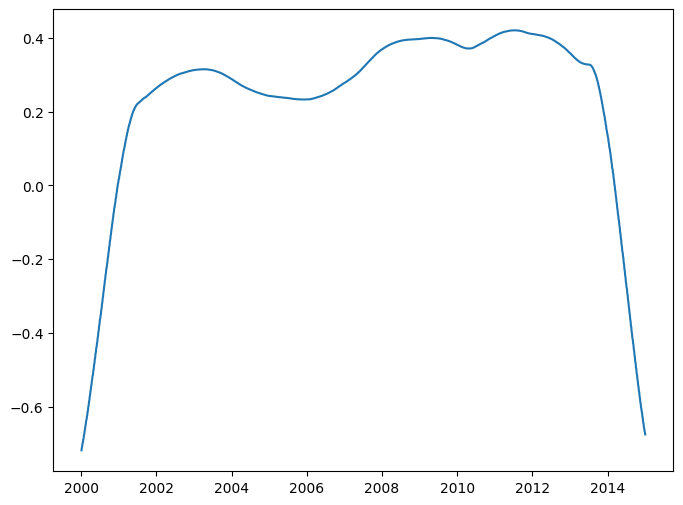

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t, pol)
# ax.set_xlim(t[100,2000])

In [ ]:
# create adjacency matrix from kendall tau
def indicator(func):
    def _f(x, epsilon):
        return func(x)  if np.abs(x) >= epsilon else 0
    return _f

In [29]:
def do_twice(func):
    def wrapper_do_twice(*args, **kwargs):
        func(*args, **kwargs)
        return func(*args, **kwargs)
    return wrapper_do_twice

In [21]:
@do_twice
def say_whee():
    print("whee")

In [22]:
say_whee()

whee
whee


In [24]:
@do_twice
def greet(name):
    print(f"Hello {name}")

greet('World')

Hello World
Hello World


In [30]:
@do_twice
def return_greeting(name):
    print("Creating greeting")
    return f"Hi {name}"

hi_adam =return_greeting("Adam")
print(hi_adam)

Creating greeting
Creating greeting
Hi Adam
